In [1]:
%pylab inline
plt.rcParams["figure.figsize"] = (8, 1)
#plt.style.use('dark_background')
import numpy as np
import numpyro
import jax
import jax.numpy as jnp
numpyro.set_host_device_count(8)
import arviz as az

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## multimodal posterior

### with HMC

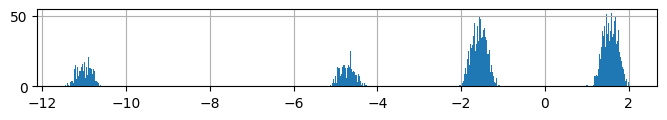

In [2]:
from numpyro import sample
from numpyro.distributions import Normal as N

def model1():
    x = numpyro.sample('xh', N(0.0, 10.0))
    y = jnp.sin(x)**8
    sample('yh', N(y, 0.2), obs=jnp.array(1.0))

nuts_kernel = numpyro.infer.NUTS(model1)
mcmc = numpyro.infer.MCMC(nuts_kernel, num_chains=8, num_warmup=500, num_samples=500, progress_bar=False)
key = jax.random.PRNGKey(0)
mcmc.run(key);
xh = mcmc.get_samples()['xh']
figure(figsize=(8,1)); hist(xh, 1000); grid(1)

### with MvNormal guide

100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 3197.75it/s, init loss: 16.4090, avg. loss [1901-2000]: 3.2134]


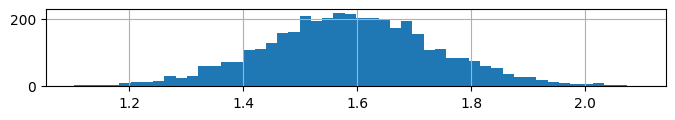

In [3]:
guide1 = numpyro.infer.autoguide.AutoMultivariateNormal(model1)
svi = numpyro.infer.SVI(
    model1,
    guide1,
    numpyro.optim.Adam(step_size=1e-2),
    loss=numpyro.infer.Trace_ELBO()
)
result = svi.run(key, 2000)
vi_pred = numpyro.infer.Predictive(guide1, params=result.params, num_samples=4000)
vi_samp = vi_pred(key)
figure(figsize=(8,1)); hist(vi_samp['xh'], 50); grid(1)

This is expected, but now we can try some of the more interesting possibilities.

### custom guide

such as creating a custom guide.  for that we need a distribution we can sample from.  To match the model used above, we need some extra work to create a CDF for sampling,

([<matplotlib.lines.Line2D at 0x28dcbb5e0>], None)

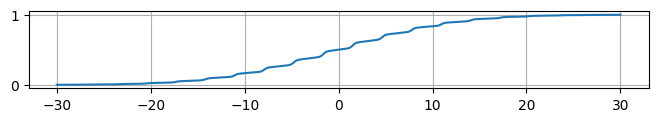

In [4]:
d = N(0,10)
x = jnp.r_[-30:30:500j]
lf = d.log_prob(x) + 2*jnp.sin(x)**8
f = jnp.exp(lf)
f = f / f.sum()
F = jnp.cumsum(f)
plot(x, F), grid(1)

With a CDF we can evaluate log prob and sample,

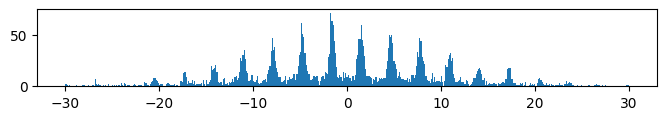

In [5]:
hist(
    jnp.interp(jax.random.uniform(key,shape=(4000,)), F, x),
    500
);

In [6]:
class CustomDistribution(numpyro.distributions.Distribution):
    support = numpyro.distributions.constraints.real
    
    def __init__(self):
        super().__init__()
        d = N(0,10)
        x = jnp.r_[-30:30:500j]
        lf = d.log_prob(x) + 2*jnp.sin(x)**8
        f = jnp.exp(lf)
        f = f / f.sum()
        F = jnp.cumsum(f)
        self.parts = x, lf, F

    def sample(self, key, sample_shape=()):
        x, lf, F = self.parts
        u = jax.random.uniform(key, shape=sample_shape)
        return jnp.interp(u, F, x)

    def log_prob(self, value):
        x, lf, F = self.parts
        return jnp.interp(value, x, lf)

  0%|                                                                                                     | 0/2000 [00:00<?, ?it/s]/Users/duke/.local/share/virtualenvs/vbjax-l9CsAOUn/lib/python3.9/site-packages/jax/_src/linear_util.py:165: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'a'}
  ans = self.f(*args, **dict(self.params, **kwargs))
100%|██████████████████████████████████████| 2000/2000 [00:00<00:00, 3552.06it/s, init loss: 2.1111, avg. loss [1901-2000]: 6.4880]


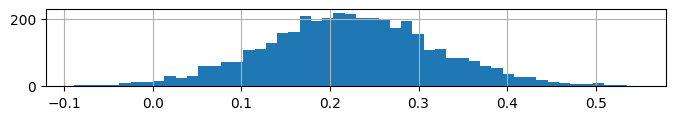

In [7]:
def myguide1():
    a = numpyro.sample('a', CustomDistribution())
    x = numpyro.sample('xh', N(a, 0.1))

svi = numpyro.infer.SVI(
    model1,
    myguide1,
    numpyro.optim.Adam(step_size=1e-2),
    loss=numpyro.infer.Trace_ELBO()
)
result = svi.run(key, 2000)
vi_pred = numpyro.infer.Predictive(guide1, params=result.params, num_samples=4000)
vi_samp = vi_pred(key)
figure(figsize=(8,1)); hist(vi_samp['xh'], 50); grid(1)

In [8]:
result.params

{}

That's not nearly as effective as expected: there's a missing piece somewhere.  Let's try Stein VI anyway,

### Stein guide

The Stein implementation here works by creating a guide per Stein particle. 

100%|██████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:38<00:00, 20.39it/s]


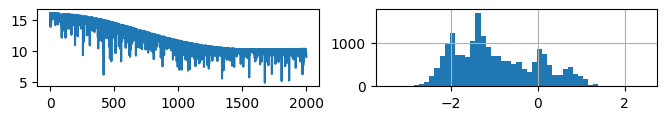

In [9]:
from numpyro.contrib.einstein import RBFKernel, SteinVI

guide1 = numpyro.infer.autoguide.AutoDiagonalNormal(model1)

svi = SteinVI(
    model1,
    guide1,
    numpyro.optim.Adam(step_size=1e-3),
    numpyro.infer.Trace_ELBO(),
    RBFKernel(),
    num_particles=400,  # number of Stein particles
    repulsion_temperature=15.0
)

result = svi.run(key, 2000)
vi_pred = numpyro.infer.Predictive(guide1, params=result.params, num_samples=50)
vi_samp = vi_pred(key)
subplot(121); plot(result.losses)
subplot(122); hist(vi_samp['xh'].ravel(), 50); grid(1)